In [9]:
"""
Implementation of a simple multivalent binding model.
"""

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from src.MBmodel import cytBindingModel, SigData

In [6]:
def fitFunc():
    "Runs least squares fitting for various model parameters, and returns the minimizers"
    x0 = np.array([-12, 1.0, 8.6, 8, 8, 7.6, 7, 7, 9.08, 8, 8, 8.59, 7, 7])  # KXSTAR, slopeT1h, slopeT1m, mIL4-IL4Ra, mIL4-Gamma, mIL4-IL13Ra, mNeo4-IL4Ra, mNeo4-Gamma, mNeo4-IL13Ra, hIL4-IL4Ra, hIL4-Gamma, hIL4-IL13Ra, hNeo4-IL4Ra, hNeo4-Gamma, hNeo4-IL13Ra (Log 10)
    bnds = ((-14, -10), (0, 10), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11))
    parampredicts = minimize(resids, x0, method='L-BFGS-B', bounds=bnds, options={"disp": 999})
    assert parampredicts.success
    return parampredicts.x

def resids(x, retDF=False):
    """"Returns residuals against signaling data"""
    masterSTAT = pd.DataFrame(columns={"Cell", "Ligand", "Concentration", "Animal", "Experimental", "Predicted"})
    Kx = x[0]
    relRecp = x[1]
    xPow = np.power(10, x)

    CplxDict = {"mIL4": [xPow[2], xPow[3], xPow[4]],
    "mNeo4": [xPow[5], xPow[6], xPow[7]],
    "hIL4": [xPow[8], xPow[9], xPow[10]],
    "hNeo4": [xPow[11], xPow[12], xPow[13]]}

    for cell in SigData.Cell.unique():
        for animal in SigData.loc[SigData.Cell == cell].Animal.unique():
            for ligand in SigData.loc[(SigData.Cell == cell) & (SigData.Animal == animal)].Ligand.unique():
                isoData = SigData.loc[(SigData.Cell == cell) & (SigData.Animal == animal) & (SigData.Ligand == ligand)]
                Concs = isoData.Concentration.values
                normSigs = isoData.Signal.values
                ligCplx = CplxDict[ligand]
                if animal == "Human":
                    results = cytBindingModel(Kx, ligCplx, Concs, cell, animal, relRecp)
                else:
                    results = cytBindingModel(Kx, ligCplx, Concs, cell, animal, relRecp)
                masterSTAT = masterSTAT.append(pd.DataFrame({"Cell": cell, "Ligand": ligand, "Concentration": Concs, "Animal": animal, "Experimental": normSigs, "Predicted": results}))
            
            # Normalize
            masterSTAT.loc[(masterSTAT.Cell == cell) & (masterSTAT.Animal == animal), "Predicted"] /= masterSTAT.loc[(masterSTAT.Cell == cell) & (masterSTAT.Animal == animal)].Predicted.max()
            masterSTAT.loc[(masterSTAT.Cell == cell) & (masterSTAT.Animal == animal), "Experimental"] /= masterSTAT.loc[(masterSTAT.Cell == cell) & (masterSTAT.Animal == animal)].Experimental.max()

    if retDF:
        return masterSTAT
    else:
        print(np.linalg.norm(masterSTAT.Predicted.values - masterSTAT.Experimental.values))
        return np.linalg.norm(masterSTAT.Predicted.values - masterSTAT.Experimental.values)

In [7]:
xOpt = fitFunc()

0361003368
3.000103611491718
3.000103612981809
3.0001036122677363
3.0001036120867117
3.0001036118112028
3.0001036132671337
3.0001036124368015
3.0001036140341677
3.000103610392604
3.0001036119621958
3.00010361255625
3.000103612803819
2.977629642288888
2.9776296487343195
2.977629662865511
2.977629641484583
2.9776296421036843
2.9776296440450563
2.977629640096466
2.9776296418163244
2.9776296390874646
2.977629641161807
2.977629642571405
2.9776296408624074
2.9776296419827575
2.977629642931697
2.977629642637865
2.9406951238373877
2.940695127309942
2.940695103986539
2.9406951217467263
2.94069512343554
2.9406951253152815
2.940695122644867
2.940695123481337
2.940695123822315
2.940695122140499
2.9406951229555034
2.940695123144492
2.9406951231692218
2.940695123601198
2.940695124146822
2.9198962883845487
2.9198962918815305
2.9198963011880803
2.919896287500835
2.9198962882103316
2.919896289935398
2.9198962876714227
2.919896288348721
2.9198962871152143
2.9198962872216603
2.9198962886064983
2.91989628

<AxesSubplot:xlabel='Experimental', ylabel='Predicted'>

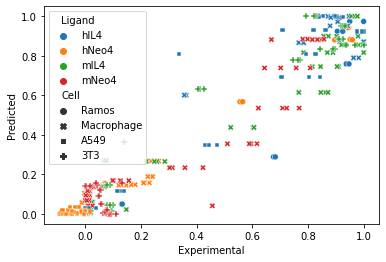

In [13]:
modelDF = resids(xOpt, True)
sns.scatterplot(data=modelDF, x="Experimental", y="Predicted", hue="Ligand", style="Cell")